# check properties of images

In [55]:
import numpy as np

In [56]:
from PIL import Image
image_path = "/home/pasquale/Documents/card_e_ifo_originali/card/backup/ill/CARD1BS-17.tif"
image = Image.open(image_path)
print(f"Image mode: {image.mode}") #if I;16 don't forget to convert to rgb

Image mode: I;16


In [57]:
img_array = np.array(image)
img_array.shape

(2538, 1197)

# extract target value from excels

In [58]:
import pandas as pd
file_path = "/home/pasquale/Documents/card_e_ifo_originali/card/per_paziente_enh_noskin/"

name_files = ["roi_benigne_Card_CC_fixed.xlsx","roi_maligne_Card_CC_fixed.xlsx","roi_sane_1_CARD_fixed.xlsx"]


## import data

In [59]:
# Read the Excel file
df_benigne = pd.read_excel(file_path+name_files[0], skiprows=0, header=0)
# Display the first few rows of the DataFrame
df_benigne["malata"]=1
df_benigne.head()

,Global ID,slice,IS,x_centroide_1,y_centroide_1,width_1,height_1,malata
0,CARD100BS-18,18,1,910,1036,361,222,1
1,CARD100BS-19,19,1,910,1036,361,222,1
2,CARD100BS-20,20,1,910,1036,361,222,1
3,CARD100BS-21,21,1,910,1036,361,222,1
4,CARD100BS-22,22,1,910,1036,361,222,1


In [60]:
# Read the Excel file
df_maligne = pd.read_excel(file_path+name_files[1], skiprows=0, header=0)
df_maligne["malata"]=1
# Rename the column 'info' to 'slice'
df_maligne.rename(columns={'info': 'slice'}, inplace=True)
# Display the first few rows of the DataFrame
df_maligne.head()

,Global ID,slice,IS,x_centroide_1,y_centroide_1,width_1,height_1,malata
0,CARD100S-22,22,1,570,1067,497,426,1
1,CARD100S-23,23,1,570,1067,497,426,1
2,CARD100S-24,24,1,570,1067,497,426,1
3,CARD100S-25,25,1,570,1067,497,426,1
4,CARD100S-26,26,1,570,1067,497,426,1


In [61]:
# Check the column names ##
print(df_maligne.columns)

Index(['Global ID', 'slice', 'IS', 'x_centroide_1', 'y_centroide_1', 'width_1',
       'height_1', 'malata'],
      dtype='object')


In [62]:
# Read the Excel file
df_sane = pd.read_excel(file_path+name_files[2], skiprows=0, header=0)
df_sane["malata"]=0
# Display the first few rows of the DataFrame
df_sane.head()

,Global ID,slice,IS,x_centroide_1,y_centroide_1,width_1,height_1,malata
0,CARD10S-4,4,1,648,460,250,250,0
1,CARD10S-5,5,1,601,1182,250,250,0
2,CARD10S-6,6,1,444,753,250,250,0
3,CARD10S-7,7,1,766,441,250,250,0
4,CARD10S-8,8,1,604,1334,250,250,0


In [63]:
df = pd.concat([df_benigne,df_sane,df_maligne],ignore_index=True)

df.head()

,Global ID,slice,IS,x_centroide_1,y_centroide_1,width_1,height_1,malata
0,CARD100BS-18,18,1,910,1036,361,222,1
1,CARD100BS-19,19,1,910,1036,361,222,1
2,CARD100BS-20,20,1,910,1036,361,222,1
3,CARD100BS-21,21,1,910,1036,361,222,1
4,CARD100BS-22,22,1,910,1036,361,222,1


In [64]:
def crop_image( image, center_x, center_y, width =600,height=600):
    crop_size=600
    """Crop the image centered at (center_x, center_y) with a size of crop_size."""
    left = max(center_x - crop_size // 2, 0)
    top = max(center_y - crop_size // 2, 0)
    right = min(center_x + crop_size // 2, image.width)
    bottom = min(center_y + crop_size // 2, image.height)

    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))

    # Optional: If the crop is smaller than the required size, you can pad it
    # (this part is optional and depends on your use case)
    if cropped_image.size != (crop_size, crop_size):
        cropped_image = cropped_image.resize((crop_size, crop_size))

    return cropped_image

In [65]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TumorDataset(Dataset):
    def __init__(self, root_dir,df=df, transform=None):
        """
        Args:
            root_dir (string): Directory with subfolders `sane` and `ill`.
            df: dataframe with centroids and area
            transform (callable, optional): Optional transforms to be applied
                on a sample (e.g., resizing, normalization).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.df = df


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # Get the image filename and the label from the dataframe
        img_name = self.df.iloc[idx]['Global ID'] 
        label = self.df.iloc[idx]['malata']   
        centroid_x, centroid_y = self.df.iloc[idx]['width_1'],self.df.iloc[idx]['height_1']
        
        # Determine the folder path based on the label
        if label == 0:
            folder = 'Sane'
        else:
            folder = 'ill'

        # Construct the full path to the image
        img_path = os.path.join(self.root_dir, folder, img_name) +".tif"


        
        image = Image.open(img_path).convert('RGB')  # Convert to RGB for consistency
        # Crop the image centered at (centroid_x, centroid_y)
        image = crop_image(image, centroid_x, centroid_y, width=600,height=600)
        
        if self.transform:
            image = self.transform(image)

        return image, label

# instantiate dataset

In [66]:
root_dir = '/home/pasquale/Documents/card_e_ifo_originali/card/backup'

In [67]:
from torchvision import transforms

transform = transforms.Compose([
    #transforms.Resize((256, 256)),  # Resize to fixed size
    transforms.ToTensor(),         # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [68]:
# Instantiate Dataset
dataset = TumorDataset(root_dir=root_dir,df=df, transform=transform)

In [69]:
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

# Example usage
for images, labels in dataloader:
    print(images.shape)  # (batch_size, 3, 256, 256)
    print(labels)        # Tensor of size (batch_size,)
    break

torch.Size([16, 3, 600, 600])
tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1])


## verify the loader

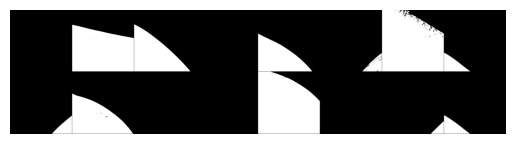

tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])


In [70]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to unnormalize a batch of images
def unnormalize_batch(batch):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return batch * std + mean

# Get a batch of images from DataLoader
images, labels = next(iter(dataloader))
# Unnormalize the batch
unnormalized_images = unnormalize_batch(images)

# Make a grid of images (default NCHW format)
img_grid = make_grid(unnormalized_images)

# Convert the grid to HWC format for visualization
npimg = img_grid.numpy()  # Convert from tensor to numpy array
npimg = np.transpose(npimg, (1, 2, 0))  # Convert from CHW to HWC
npimg = np.clip(npimg, 0, 1)  # Clip values to [0, 1]

# Display the grid
plt.imshow(npimg)
plt.axis('off')  # Optional: hide axes for better visualization
plt.show()

# Print the labels for the batch
print(labels)

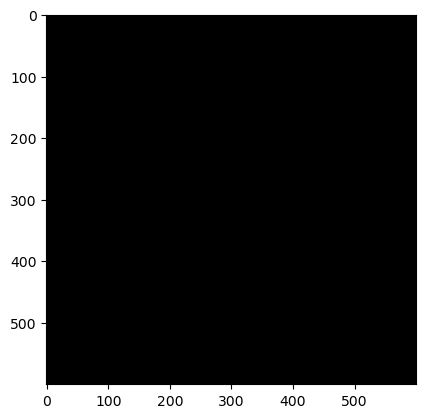

In [71]:

# Visualize the first image in the batch
image = unnormalized_images[0].permute(1, 2, 0).numpy()  # Convert to HWC
plt.imshow(np.clip(image, 0, 1))
plt.show()